# About this notebook
- Deberta-v3-large starter code
- pip wheels is [here](https://www.kaggle.com/code/yasufuminakama/pppm-pip-wheels)
- Inference notebook is [here](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-inference)

If this notebook is helpful, feel free to upvote :)

In [1]:
import os
import time
wait_to_make = "trained_list/gpt-net.txt"
count = 0
while 1:
    if os.path.exists(wait_to_make):
        break
    print(f'sleep {count} h')
    time.sleep(3600)
    count+=1
    
local = True

In [2]:
EXP_NAME = "xlnet-base-cased"


In [3]:
# !nvidia-smi

In [4]:
# ! pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio===0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

In [5]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.9.0+cu111
True


# Directory settings

In [6]:
# ====================================================
# Directory settings
# ====================================================

import os
import datetime
if local:
    INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'
else:
    INPUT_DIR = '../../data/us-patent-phrase-to-phrase-matching/'

OUTPUT_DIR = f'./output/{EXP_NAME}/'
# if not os.path.exists(OUTPUT_DIR):
os.makedirs(OUTPUT_DIR, exist_ok=True)


# CFG

In [7]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    competition='PPPM'
    _wandb_kernel='nakama'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    # model="microsoft/deberta-v3-large"
    model = "xlnet-base-cased"
    # size = "large
    # model = f"{model}-{size}"
    if "small" in model:
        hidden_state = hiddden_state_fix = 512
    elif "base" in model or "medium" in model:
        hidden_state = hiddden_state_fix = 768
    elif "large" in model:
        hidden_state = hiddden_state_fix = 1024
    elif "xlarge" in model:
        hidden_state =  1536
        
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=4
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    
    batch_size=8
    
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[i for i in range(n_fold)]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [8]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

In [9]:
# !pip install transformers==4.16.2
# !pip install tokenizers==0.11.0

# Library

In [10]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# device = torch.device('cpu')
print(device)

start = time.time()

torch.__version__: 1.9.0+cu111
tokenizers.__version__: 0.11.0
transformers.__version__: 4.16.2
env: TOKENIZERS_PARALLELISM=true
cuda


# Utils

In [11]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [12]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [13]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir(INPUT_DIR+'CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'{INPUT_DIR}CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


# cpc_texts = get_cpc_texts()
# torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
cpc_texts = torch.load(INPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [14]:
pad = "[SEP]"
train['text'] = train['anchor'] + pad + train['target'] +pad  + train['context_text']
test['text'] = test['anchor'] + pad + test['target'] +pad  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


# EDA

<AxesSubplot:>

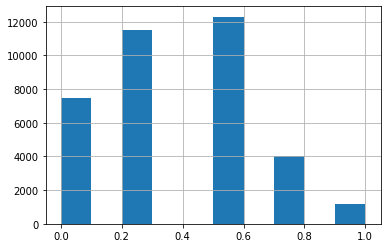

In [15]:
train['score'].hist()

In [16]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [17]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [18]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [19]:
# !pip install --no-cache-dir sentencepiece

In [20]:
# ====================================================
# tokenizer
# ====================================================
# tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer = AutoTokenizer.from_pretrained(CFG.model,use_fast=False)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer



# Dataset

In [21]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 197


In [22]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

sys.path.append('../dataset')
from dataset import TrainDataset

torch.__version__: 1.9.0+cu111


In [23]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [24]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output
    


# Helpler functions

In [25]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [26]:
# ====================================================
# train loop
# ====================================================
# def train_loop(folds, fold):
def train_loop(train_loader, valid_loader):
#     LOGGER.info(f"========== fold: {fold} training ==========")

#     # ====================================================
#     # loader
#     # ====================================================
#     train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
#     valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
#     valid_labels = valid_folds['score'].values
    
#     train_dataset = TrainDataset(CFG, train_folds)
#     valid_dataset = TrainDataset(CFG, valid_folds)

#     train_loader = DataLoader(train_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=True,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
#     valid_loader = DataLoader(valid_dataset,
#                               batch_size=CFG.batch_size,
#                               shuffle=False,
#                               num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):
        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [27]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            # if fold in [0,1,2]:
                #continue
               # print（f”￥０r３３［３８；５；４０m＝＝＝＝＝＝＝＝＝＝ this fold is pass ￥ontinue
            LOGGER.info(f"========== fold: {fold} training ==========")
            print(f"\033[38;5;40m========== fold: {fold} training ==========\033[0m");
            if fold in CFG.trn_fold:
                # ====================================================
                # loader
                # ====================================================
                folds = train
                train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
                valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
                valid_labels = valid_folds['score'].values

                train_dataset = TrainDataset(CFG, train_folds)
                valid_dataset = TrainDataset(CFG, valid_folds)

                train_loader = DataLoader(train_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=True,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
                valid_loader = DataLoader(valid_dataset,
                                          batch_size=CFG.batch_size,
                                          shuffle=False,
                                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

#                 _oof_df = train_loop(train, fold)
                _oof_df = train_loop(train_loader, valid_loader)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


========== fold: 0 training ==========


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/3419] Elapsed 0m 1s (remain 99m 20s) Loss: 0.6643(0.6643) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 30s (remain 16m 54s) Loss: 0.7689(0.7005) Grad: 13688.4023  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 0m 50s (remain 13m 30s) Loss: 0.6141(0.6726) Grad: 23835.1250  LR: 0.00001999  
Epoch: [1][300/3419] Elapsed 1m 10s (remain 12m 9s) Loss: 0.6244(0.6611) Grad: 5188.5967  LR: 0.00001998  
Epoch: [1][400/3419] Elapsed 1m 30s (remain 11m 18s) Loss: 0.6526(0.6501) Grad: 10845.9102  LR: 0.00001996  
Epoch: [1][500/3419] Elapsed 1m 49s (remain 10m 40s) Loss: 0.6137(0.6469) Grad: 5963.7812  LR: 0.00001993  
Epoch: [1][600/3419] Elapsed 2m 9s (remain 10m 8s) Loss: 0.5829(0.6424) Grad: 5688.8071  LR: 0.00001990  
Epoch: [1][700/3419] Elapsed 2m 29s (remain 9m 39s) Loss: 0.4634(0.6364) Grad: 8533.5205  LR: 0.00001987  
Epoch: [1][800/3419] Elapsed 2m 49s (remain 9m 13s) Loss: 0.6686(0.6325) Grad: 9134.2061  LR: 0.00001983  
Epoch: [1][900/3419] Elapsed 3m 9s (rem

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 54s) Loss: 0.5972(0.5972) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 31s) Loss: 0.6253(0.5658) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 21s) Loss: 0.4007(0.5765) 
EVAL: [300/1140] Elapsed 0m 26s (remain 1m 12s) Loss: 0.9550(0.5743) 
EVAL: [400/1140] Elapsed 0m 34s (remain 1m 4s) Loss: 0.5095(0.5720) 
EVAL: [500/1140] Elapsed 0m 43s (remain 0m 55s) Loss: 0.5754(0.5764) 
EVAL: [600/1140] Elapsed 0m 52s (remain 0m 46s) Loss: 0.5558(0.5754) 
EVAL: [700/1140] Elapsed 1m 0s (remain 0m 38s) Loss: 0.6558(0.5774) 
EVAL: [800/1140] Elapsed 1m 9s (remain 0m 29s) Loss: 0.7750(0.5762) 
EVAL: [900/1140] Elapsed 1m 17s (remain 0m 20s) Loss: 0.5448(0.5770) 
EVAL: [1000/1140] Elapsed 1m 26s (remain 0m 12s) Loss: 0.5667(0.5783) 
EVAL: [1100/1140] Elapsed 1m 35s (remain 0m 3s) Loss: 0.6419(0.5787) 


Epoch 1 - avg_train_loss: 0.5977  avg_val_loss: 0.5778  time: 786s
Epoch 1 - Score: 0.7486
Epoch 1 - Save Best Score: 0.7486 Model


EVAL: [1139/1140] Elapsed 1m 38s (remain 0m 0s) Loss: 0.6349(0.5778) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 30m 35s) Loss: 0.4512(0.4512) Grad: 126060.5156  LR: 0.00001707  
Epoch: [2][100/3419] Elapsed 0m 20s (remain 11m 3s) Loss: 0.5529(0.5744) Grad: 57229.9414  LR: 0.00001691  
Epoch: [2][200/3419] Elapsed 0m 39s (remain 10m 39s) Loss: 0.5245(0.5620) Grad: 13074.0771  LR: 0.00001674  
Epoch: [2][300/3419] Elapsed 0m 59s (remain 10m 18s) Loss: 0.4454(0.5618) Grad: 13095.4463  LR: 0.00001657  
Epoch: [2][400/3419] Elapsed 1m 19s (remain 9m 58s) Loss: 0.5474(0.5618) Grad: 10096.0205  LR: 0.00001639  
Epoch: [2][500/3419] Elapsed 1m 39s (remain 9m 38s) Loss: 0.4459(0.5594) Grad: 12102.0078  LR: 0.00001621  
Epoch: [2][600/3419] Elapsed 1m 59s (remain 9m 21s) Loss: 0.2904(0.5592) Grad: 5205.0522  LR: 0.00001603  
Epoch: [2][700/3419] Elapsed 2m 19s (remain 9m 0s) Loss: 0.6436(0.5590) Grad: 15465.6553  LR: 0.00001585  
Epoch: [2][800/3419] Elapsed 2m 39s (remain 8m 40s) Loss: 0.4806(0.5593) Grad: 24210.6523  LR: 0.00001566  
Epoch: [2][900/3419] Elapsed 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][3418/3419] Elapsed 11m 17s (remain 0m 0s) Loss: 0.6144(0.5570) Grad: 10863.5010  LR: 0.00001000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 43s) Loss: 0.6097(0.6097) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 31s) Loss: 0.5618(0.5781) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 21s) Loss: 0.4388(0.5762) 
EVAL: [300/1140] Elapsed 0m 26s (remain 1m 12s) Loss: 0.7118(0.5721) 
EVAL: [400/1140] Elapsed 0m 34s (remain 1m 3s) Loss: 0.5647(0.5693) 
EVAL: [500/1140] Elapsed 0m 43s (remain 0m 55s) Loss: 0.5686(0.5741) 
EVAL: [600/1140] Elapsed 0m 51s (remain 0m 46s) Loss: 0.5762(0.5705) 
EVAL: [700/1140] Elapsed 1m 0s (remain 0m 37s) Loss: 0.6226(0.5714) 
EVAL: [800/1140] Elapsed 1m 9s (remain 0m 29s) Loss: 0.7757(0.5703) 
EVAL: [900/1140] Elapsed 1m 17s (remain 0m 20s) Loss: 0.5126(0.5710) 
EVAL: [1000/1140] Elapsed 1m 26s (remain 0m 12s) Loss: 0.5732(0.5729) 
EVAL: [1100/1140] Elapsed 1m 35s (remain 0m 3s) Loss: 0.5046(0.5730) 


Epoch 2 - avg_train_loss: 0.5570  avg_val_loss: 0.5722  time: 776s
Epoch 2 - Score: 0.7799
Epoch 2 - Save Best Score: 0.7799 Model


EVAL: [1139/1140] Elapsed 1m 38s (remain 0m 0s) Loss: 0.6143(0.5722) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 31m 59s) Loss: 0.6269(0.6269) Grad: 88231.1641  LR: 0.00001000  
Epoch: [3][100/3419] Elapsed 0m 20s (remain 11m 5s) Loss: 0.5203(0.5289) Grad: 20829.2754  LR: 0.00000977  
Epoch: [3][200/3419] Elapsed 0m 40s (remain 10m 40s) Loss: 0.4386(0.5379) Grad: 39858.8164  LR: 0.00000954  
Epoch: [3][300/3419] Elapsed 0m 59s (remain 10m 19s) Loss: 0.6893(0.5360) Grad: 17826.3945  LR: 0.00000931  
Epoch: [3][400/3419] Elapsed 1m 19s (remain 9m 59s) Loss: 0.5301(0.5373) Grad: 13509.9141  LR: 0.00000908  
Epoch: [3][500/3419] Elapsed 1m 39s (remain 9m 38s) Loss: 0.6204(0.5365) Grad: 2976.7488  LR: 0.00000885  
Epoch: [3][600/3419] Elapsed 1m 59s (remain 9m 18s) Loss: 0.4732(0.5372) Grad: 6638.4580  LR: 0.00000863  
Epoch: [3][700/3419] Elapsed 2m 18s (remain 8m 58s) Loss: 0.5939(0.5373) Grad: 21345.3047  LR: 0.00000840  
Epoch: [3][800/3419] Elapsed 2m 38s (remain 8m 38s) Loss: 0.5652(0.5364) Grad: 2403.8784  LR: 0.00000817  
Epoch: [3][900/3419] Elapsed 2m

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 4m 40s) Loss: 0.5871(0.5871) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 30s) Loss: 0.5456(0.5877) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 21s) Loss: 0.4230(0.5866) 
EVAL: [300/1140] Elapsed 0m 26s (remain 1m 12s) Loss: 0.7913(0.5806) 
EVAL: [400/1140] Elapsed 0m 34s (remain 1m 3s) Loss: 0.5272(0.5770) 
EVAL: [500/1140] Elapsed 0m 43s (remain 0m 55s) Loss: 0.5636(0.5810) 
EVAL: [600/1140] Elapsed 0m 51s (remain 0m 46s) Loss: 0.6258(0.5789) 
EVAL: [700/1140] Elapsed 1m 0s (remain 0m 37s) Loss: 0.6290(0.5789) 
EVAL: [800/1140] Elapsed 1m 9s (remain 0m 29s) Loss: 0.8004(0.5761) 
EVAL: [900/1140] Elapsed 1m 17s (remain 0m 20s) Loss: 0.5531(0.5756) 
EVAL: [1000/1140] Elapsed 1m 26s (remain 0m 11s) Loss: 0.5725(0.5770) 
EVAL: [1100/1140] Elapsed 1m 34s (remain 0m 3s) Loss: 0.5026(0.5769) 


Epoch 3 - avg_train_loss: 0.5360  avg_val_loss: 0.5763  time: 774s
Epoch 3 - Score: 0.7963
Epoch 3 - Save Best Score: 0.7963 Model


EVAL: [1139/1140] Elapsed 1m 38s (remain 0m 0s) Loss: 0.6140(0.5763) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 38m 15s) Loss: 0.4156(0.4156) Grad: 64547.5312  LR: 0.00000293  
Epoch: [4][100/3419] Elapsed 0m 20s (remain 11m 6s) Loss: 0.6270(0.5321) Grad: 27986.6426  LR: 0.00000277  
Epoch: [4][200/3419] Elapsed 0m 39s (remain 10m 39s) Loss: 0.5219(0.5289) Grad: 10750.6240  LR: 0.00000261  
Epoch: [4][300/3419] Elapsed 0m 59s (remain 10m 18s) Loss: 0.5495(0.5275) Grad: 11804.6348  LR: 0.00000246  
Epoch: [4][400/3419] Elapsed 1m 19s (remain 9m 57s) Loss: 0.3481(0.5268) Grad: 10757.1445  LR: 0.00000231  
Epoch: [4][500/3419] Elapsed 1m 39s (remain 9m 37s) Loss: 0.5708(0.5263) Grad: 48168.5977  LR: 0.00000216  
Epoch: [4][600/3419] Elapsed 1m 58s (remain 9m 17s) Loss: 0.5077(0.5268) Grad: 11200.8125  LR: 0.00000202  
Epoch: [4][700/3419] Elapsed 2m 18s (remain 8m 57s) Loss: 0.4908(0.5261) Grad: 12105.8164  LR: 0.00000189  
Epoch: [4][800/3419] Elapsed 2m 38s (remain 8m 37s) Loss: 0.4956(0.5247) Grad: 19089.4512  LR: 0.00000176  
Epoch: [4][900/3419] Elapsed

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][3418/3419] Elapsed 11m 15s (remain 0m 0s) Loss: 0.6532(0.5236) Grad: 7976.4351  LR: 0.00000000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 16m 17s) Loss: 0.5797(0.5797) 
EVAL: [100/1140] Elapsed 0m 9s (remain 1m 37s) Loss: 0.5432(0.5939) 
EVAL: [200/1140] Elapsed 0m 18s (remain 1m 24s) Loss: 0.4230(0.5963) 
EVAL: [300/1140] Elapsed 0m 26s (remain 1m 14s) Loss: 0.8169(0.5887) 
EVAL: [400/1140] Elapsed 0m 35s (remain 1m 5s) Loss: 0.5119(0.5841) 
EVAL: [500/1140] Elapsed 0m 44s (remain 0m 56s) Loss: 0.5621(0.5883) 
EVAL: [600/1140] Elapsed 0m 53s (remain 0m 48s) Loss: 0.6438(0.5855) 
EVAL: [700/1140] Elapsed 1m 2s (remain 0m 39s) Loss: 0.6459(0.5862) 
EVAL: [800/1140] Elapsed 1m 11s (remain 0m 30s) Loss: 0.8545(0.5831) 
EVAL: [900/1140] Elapsed 1m 19s (remain 0m 21s) Loss: 0.4827(0.5830) 
EVAL: [1000/1140] Elapsed 1m 28s (remain 0m 12s) Loss: 0.5637(0.5851) 
EVAL: [1100/1140] Elapsed 1m 37s (remain 0m 3s) Loss: 0.5069(0.5855) 


Epoch 4 - avg_train_loss: 0.5236  avg_val_loss: 0.5848  time: 776s
Epoch 4 - Score: 0.8014
Epoch 4 - Save Best Score: 0.8014 Model


EVAL: [1139/1140] Elapsed 1m 40s (remain 0m 0s) Loss: 0.6090(0.5848) 


========== fold: 0 result ==========
Score: 0.8014
========== fold: 1 training ==========


========== fold: 1 training ==========


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][0/3419] Elapsed 0m 0s (remain 35m 41s) Loss: 1.1331(1.1331) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 20s (remain 11m 5s) Loss: 0.6936(0.6888) Grad: 16005.6475  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 0m 39s (remain 10m 40s) Loss: 0.7281(0.6666) Grad: 66732.8984  LR: 0.00001999  
Epoch: [1][300/3419] Elapsed 0m 59s (remain 10m 19s) Loss: 0.5681(0.6526) Grad: 13128.1973  LR: 0.00001998  
Epoch: [1][400/3419] Elapsed 1m 19s (remain 9m 58s) Loss: 0.6100(0.6421) Grad: 13261.4014  LR: 0.00001996  
Epoch: [1][500/3419] Elapsed 1m 39s (remain 9m 38s) Loss: 0.5958(0.6366) Grad: 16681.9668  LR: 0.00001993  
Epoch: [1][600/3419] Elapsed 1m 59s (remain 9m 18s) Loss: 0.5736(0.6329) Grad: 9668.4902  LR: 0.00001990  
Epoch: [1][700/3419] Elapsed 2m 18s (remain 8m 58s) Loss: 0.6878(0.6286) Grad: 16973.9004  LR: 0.00001987  
Epoch: [1][800/3419] Elapsed 2m 38s (remain 8m 38s) Loss: 0.5533(0.6251) Grad: 10863.0078  LR: 0.00001983  
Epoch: [1][900/3419] Elapsed 2m 58s 

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][3418/3419] Elapsed 11m 16s (remain 0m 0s) Loss: 0.5711(0.5948) Grad: 35403.9258  LR: 0.00001707  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 19s) Loss: 0.5436(0.5436) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 31s) Loss: 0.5204(0.5466) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 21s) Loss: 0.5375(0.5583) 
EVAL: [300/1140] Elapsed 0m 26s (remain 1m 12s) Loss: 0.6275(0.5592) 
EVAL: [400/1140] Elapsed 0m 34s (remain 1m 4s) Loss: 0.3673(0.5620) 
EVAL: [500/1140] Elapsed 0m 43s (remain 0m 55s) Loss: 0.5978(0.5636) 
EVAL: [600/1140] Elapsed 0m 51s (remain 0m 46s) Loss: 0.5858(0.5632) 
EVAL: [700/1140] Elapsed 1m 0s (remain 0m 37s) Loss: 0.7005(0.5638) 
EVAL: [800/1140] Elapsed 1m 9s (remain 0m 29s) Loss: 0.6007(0.5645) 
EVAL: [900/1140] Elapsed 1m 17s (remain 0m 20s) Loss: 0.5111(0.5624) 
EVAL: [1000/1140] Elapsed 1m 26s (remain 0m 12s) Loss: 0.5463(0.5608) 
EVAL: [1100/1140] Elapsed 1m 35s (remain 0m 3s) Loss: 0.5058(0.5603) 


Epoch 1 - avg_train_loss: 0.5948  avg_val_loss: 0.5609  time: 775s
Epoch 1 - Score: 0.7733
Epoch 1 - Save Best Score: 0.7733 Model


EVAL: [1139/1140] Elapsed 1m 38s (remain 0m 0s) Loss: 1.0966(0.5609) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 27m 4s) Loss: 0.4339(0.4339) Grad: 110548.6250  LR: 0.00001707  
Epoch: [2][100/3419] Elapsed 0m 20s (remain 11m 3s) Loss: 0.6338(0.5510) Grad: 66010.0078  LR: 0.00001691  
Epoch: [2][200/3419] Elapsed 0m 39s (remain 10m 39s) Loss: 0.6104(0.5560) Grad: 22164.1094  LR: 0.00001674  
Epoch: [2][300/3419] Elapsed 0m 59s (remain 10m 17s) Loss: 0.6656(0.5595) Grad: 34547.6016  LR: 0.00001657  
Epoch: [2][400/3419] Elapsed 1m 19s (remain 9m 57s) Loss: 0.4885(0.5594) Grad: 15639.4150  LR: 0.00001639  
Epoch: [2][500/3419] Elapsed 1m 39s (remain 9m 37s) Loss: 0.5064(0.5594) Grad: 34078.4453  LR: 0.00001621  
Epoch: [2][600/3419] Elapsed 1m 58s (remain 9m 17s) Loss: 0.5467(0.5580) Grad: 32981.2031  LR: 0.00001603  
Epoch: [2][700/3419] Elapsed 2m 18s (remain 8m 57s) Loss: 0.5797(0.5587) Grad: 24291.4062  LR: 0.00001585  
Epoch: [2][800/3419] Elapsed 2m 38s (remain 8m 37s) Loss: 0.5142(0.5580) Grad: 28867.1699  LR: 0.00001566  
Epoch: [2][900/3419] Elapsed

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 4s) Loss: 0.7295(0.7295) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 31s) Loss: 0.5459(0.5580) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 21s) Loss: 0.5166(0.5644) 
EVAL: [300/1140] Elapsed 0m 26s (remain 1m 12s) Loss: 0.6111(0.5649) 
EVAL: [400/1140] Elapsed 0m 34s (remain 1m 4s) Loss: 0.3585(0.5697) 
EVAL: [500/1140] Elapsed 0m 43s (remain 0m 55s) Loss: 0.8023(0.5715) 
EVAL: [600/1140] Elapsed 0m 52s (remain 0m 46s) Loss: 0.5643(0.5718) 
EVAL: [700/1140] Elapsed 1m 0s (remain 0m 37s) Loss: 0.8064(0.5729) 
EVAL: [800/1140] Elapsed 1m 9s (remain 0m 29s) Loss: 0.6083(0.5729) 
EVAL: [900/1140] Elapsed 1m 17s (remain 0m 20s) Loss: 0.5317(0.5706) 
EVAL: [1000/1140] Elapsed 1m 26s (remain 0m 12s) Loss: 0.5748(0.5691) 
EVAL: [1100/1140] Elapsed 1m 35s (remain 0m 3s) Loss: 0.4435(0.5680) 


Epoch 2 - avg_train_loss: 0.5556  avg_val_loss: 0.5691  time: 774s
Epoch 2 - Score: 0.7879
Epoch 2 - Save Best Score: 0.7879 Model


EVAL: [1139/1140] Elapsed 1m 38s (remain 0m 0s) Loss: 1.2111(0.5691) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 30m 37s) Loss: 0.4405(0.4405) Grad: 158793.0469  LR: 0.00001000  
Epoch: [3][100/3419] Elapsed 0m 20s (remain 11m 6s) Loss: 0.5365(0.5207) Grad: 101597.0703  LR: 0.00000977  
Epoch: [3][200/3419] Elapsed 0m 40s (remain 10m 40s) Loss: 0.5813(0.5304) Grad: 27564.1973  LR: 0.00000954  
Epoch: [3][300/3419] Elapsed 0m 59s (remain 10m 19s) Loss: 0.3433(0.5337) Grad: 62255.2617  LR: 0.00000931  
Epoch: [3][400/3419] Elapsed 1m 19s (remain 9m 58s) Loss: 0.5632(0.5396) Grad: 19568.8086  LR: 0.00000908  
Epoch: [3][500/3419] Elapsed 1m 39s (remain 9m 38s) Loss: 0.3974(0.5339) Grad: 15677.8965  LR: 0.00000885  
Epoch: [3][600/3419] Elapsed 1m 59s (remain 9m 18s) Loss: 0.5905(0.5364) Grad: 179569.0000  LR: 0.00000863  
Epoch: [3][700/3419] Elapsed 2m 18s (remain 8m 58s) Loss: 0.3594(0.5360) Grad: 61089.6484  LR: 0.00000840  
Epoch: [3][800/3419] Elapsed 2m 38s (remain 8m 38s) Loss: 0.3705(0.5361) Grad: 22799.5859  LR: 0.00000817  
Epoch: [3][900/3419] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 4s) Loss: 0.7795(0.7795) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 31s) Loss: 0.5687(0.5686) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 21s) Loss: 0.5213(0.5716) 
EVAL: [300/1140] Elapsed 0m 26s (remain 1m 12s) Loss: 0.6046(0.5713) 
EVAL: [400/1140] Elapsed 0m 34s (remain 1m 3s) Loss: 0.3442(0.5771) 
EVAL: [500/1140] Elapsed 0m 43s (remain 0m 55s) Loss: 0.8806(0.5773) 
EVAL: [600/1140] Elapsed 0m 51s (remain 0m 46s) Loss: 0.5667(0.5798) 
EVAL: [700/1140] Elapsed 1m 0s (remain 0m 37s) Loss: 0.8783(0.5816) 
EVAL: [800/1140] Elapsed 1m 9s (remain 0m 29s) Loss: 0.5981(0.5805) 
EVAL: [900/1140] Elapsed 1m 17s (remain 0m 20s) Loss: 0.5799(0.5767) 
EVAL: [1000/1140] Elapsed 1m 26s (remain 0m 11s) Loss: 0.5846(0.5748) 
EVAL: [1100/1140] Elapsed 1m 34s (remain 0m 3s) Loss: 0.5545(0.5746) 


Epoch 3 - avg_train_loss: 0.5357  avg_val_loss: 0.5752  time: 774s
Epoch 3 - Score: 0.8035
Epoch 3 - Save Best Score: 0.8035 Model


EVAL: [1139/1140] Elapsed 1m 38s (remain 0m 0s) Loss: 1.6183(0.5752) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 29m 41s) Loss: 0.5186(0.5186) Grad: 294620.4062  LR: 0.00000293  
Epoch: [4][100/3419] Elapsed 0m 20s (remain 11m 4s) Loss: 0.4282(0.5188) Grad: 43415.8594  LR: 0.00000277  
Epoch: [4][200/3419] Elapsed 0m 39s (remain 10m 39s) Loss: 0.6556(0.5252) Grad: 40805.0391  LR: 0.00000261  
Epoch: [4][300/3419] Elapsed 0m 59s (remain 10m 18s) Loss: 0.6851(0.5310) Grad: 94864.4922  LR: 0.00000246  
Epoch: [4][400/3419] Elapsed 1m 19s (remain 9m 57s) Loss: 0.6418(0.5334) Grad: 15432.1787  LR: 0.00000231  
Epoch: [4][500/3419] Elapsed 1m 39s (remain 9m 37s) Loss: 0.5708(0.5357) Grad: 21327.0977  LR: 0.00000216  
Epoch: [4][600/3419] Elapsed 1m 58s (remain 9m 17s) Loss: 0.3758(0.5310) Grad: 27117.5273  LR: 0.00000202  
Epoch: [4][700/3419] Elapsed 2m 18s (remain 8m 57s) Loss: 0.6298(0.5305) Grad: 21795.3711  LR: 0.00000189  
Epoch: [4][800/3419] Elapsed 2m 38s (remain 8m 37s) Loss: 0.4942(0.5290) Grad: 34487.5430  LR: 0.00000176  
Epoch: [4][900/3419] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 1s) Loss: 0.7626(0.7626) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 31s) Loss: 0.5891(0.5772) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 21s) Loss: 0.5202(0.5792) 
EVAL: [300/1140] Elapsed 0m 26s (remain 1m 12s) Loss: 0.6034(0.5783) 
EVAL: [400/1140] Elapsed 0m 34s (remain 1m 3s) Loss: 0.3394(0.5826) 
EVAL: [500/1140] Elapsed 0m 43s (remain 0m 55s) Loss: 0.8840(0.5834) 
EVAL: [600/1140] Elapsed 0m 51s (remain 0m 46s) Loss: 0.5663(0.5849) 
EVAL: [700/1140] Elapsed 1m 0s (remain 0m 37s) Loss: 0.8825(0.5874) 
EVAL: [800/1140] Elapsed 1m 9s (remain 0m 29s) Loss: 0.5914(0.5861) 
EVAL: [900/1140] Elapsed 1m 17s (remain 0m 20s) Loss: 0.5890(0.5820) 
EVAL: [1000/1140] Elapsed 1m 26s (remain 0m 12s) Loss: 0.5878(0.5797) 
EVAL: [1100/1140] Elapsed 1m 35s (remain 0m 3s) Loss: 0.5871(0.5793) 


Epoch 4 - avg_train_loss: 0.5242  avg_val_loss: 0.5798  time: 774s
Epoch 4 - Score: 0.8048
Epoch 4 - Save Best Score: 0.8048 Model


EVAL: [1139/1140] Elapsed 1m 38s (remain 0m 0s) Loss: 1.7521(0.5798) 


========== fold: 1 result ==========
Score: 0.8048
========== fold: 2 training ==========


========== fold: 2 training ==========


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][0/3419] Elapsed 0m 0s (remain 28m 21s) Loss: 0.6401(0.6401) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 20s (remain 10m 59s) Loss: 0.6975(0.6844) Grad: 9999.4131  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 0m 39s (remain 10m 37s) Loss: 0.7207(0.6704) Grad: 9797.4648  LR: 0.00001999  
Epoch: [1][300/3419] Elapsed 0m 59s (remain 10m 16s) Loss: 0.6291(0.6632) Grad: 2128.0974  LR: 0.00001998  
Epoch: [1][400/3419] Elapsed 1m 19s (remain 9m 56s) Loss: 0.6897(0.6634) Grad: 3639.1543  LR: 0.00001996  
Epoch: [1][500/3419] Elapsed 1m 38s (remain 9m 36s) Loss: 0.6910(0.6620) Grad: 3432.6140  LR: 0.00001993  
Epoch: [1][600/3419] Elapsed 1m 58s (remain 9m 16s) Loss: 0.6431(0.6599) Grad: 9834.0645  LR: 0.00001990  
Epoch: [1][700/3419] Elapsed 2m 18s (remain 8m 56s) Loss: 0.5840(0.6569) Grad: 2960.0029  LR: 0.00001987  
Epoch: [1][800/3419] Elapsed 2m 38s (remain 8m 36s) Loss: 0.6028(0.6532) Grad: 1289.1930  LR: 0.00001983  
Epoch: [1][900/3419] Elapsed 2m 57s (remai

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][3418/3419] Elapsed 11m 15s (remain 0m 0s) Loss: 0.4942(0.6043) Grad: 7802.2788  LR: 0.00001707  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 16s) Loss: 0.5311(0.5311) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 31s) Loss: 0.8624(0.5836) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 22s) Loss: 0.6711(0.5844) 
EVAL: [300/1140] Elapsed 0m 26s (remain 1m 13s) Loss: 0.6584(0.5896) 
EVAL: [400/1140] Elapsed 0m 34s (remain 1m 4s) Loss: 0.4944(0.5935) 
EVAL: [500/1140] Elapsed 0m 43s (remain 0m 55s) Loss: 0.4627(0.5896) 
EVAL: [600/1140] Elapsed 0m 52s (remain 0m 46s) Loss: 0.3590(0.5931) 
EVAL: [700/1140] Elapsed 1m 0s (remain 0m 38s) Loss: 0.6483(0.5934) 
EVAL: [800/1140] Elapsed 1m 9s (remain 0m 29s) Loss: 0.2747(0.5958) 
EVAL: [900/1140] Elapsed 1m 17s (remain 0m 20s) Loss: 0.6042(0.5963) 
EVAL: [1000/1140] Elapsed 1m 26s (remain 0m 12s) Loss: 0.5593(0.5937) 
EVAL: [1100/1140] Elapsed 1m 35s (remain 0m 3s) Loss: 0.6462(0.5911) 


Epoch 1 - avg_train_loss: 0.6043  avg_val_loss: 0.5907  time: 774s
Epoch 1 - Score: 0.7421
Epoch 1 - Save Best Score: 0.7421 Model


EVAL: [1139/1140] Elapsed 1m 38s (remain 0m 0s) Loss: 0.4378(0.5907) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 30m 10s) Loss: 0.4613(0.4613) Grad: 109840.3984  LR: 0.00001707  
Epoch: [2][100/3419] Elapsed 0m 20s (remain 11m 6s) Loss: 0.5432(0.5700) Grad: 100660.8125  LR: 0.00001691  
Epoch: [2][200/3419] Elapsed 0m 40s (remain 10m 41s) Loss: 0.6326(0.5663) Grad: 93675.5625  LR: 0.00001674  
Epoch: [2][300/3419] Elapsed 0m 59s (remain 10m 19s) Loss: 0.6148(0.5614) Grad: 45008.1172  LR: 0.00001657  
Epoch: [2][400/3419] Elapsed 1m 19s (remain 9m 59s) Loss: 0.5952(0.5583) Grad: 48389.1133  LR: 0.00001639  
Epoch: [2][500/3419] Elapsed 1m 39s (remain 9m 39s) Loss: 0.6852(0.5609) Grad: 128412.3828  LR: 0.00001621  
Epoch: [2][600/3419] Elapsed 1m 59s (remain 9m 18s) Loss: 0.5593(0.5587) Grad: 59272.4805  LR: 0.00001603  
Epoch: [2][700/3419] Elapsed 2m 18s (remain 8m 58s) Loss: 0.6348(0.5585) Grad: 22800.1621  LR: 0.00001585  
Epoch: [2][800/3419] Elapsed 2m 38s (remain 8m 38s) Loss: 0.5218(0.5589) Grad: 59907.1055  LR: 0.00001566  
Epoch: [2][900/3419] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 7s) Loss: 0.4956(0.4956) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 31s) Loss: 0.9406(0.5748) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 21s) Loss: 0.6398(0.5691) 
EVAL: [300/1140] Elapsed 0m 26s (remain 1m 12s) Loss: 0.6303(0.5760) 
EVAL: [400/1140] Elapsed 0m 34s (remain 1m 4s) Loss: 0.4869(0.5827) 
EVAL: [500/1140] Elapsed 0m 43s (remain 0m 55s) Loss: 0.4607(0.5780) 
EVAL: [600/1140] Elapsed 0m 51s (remain 0m 46s) Loss: 0.3932(0.5831) 
EVAL: [700/1140] Elapsed 1m 0s (remain 0m 37s) Loss: 0.6616(0.5826) 
EVAL: [800/1140] Elapsed 1m 9s (remain 0m 29s) Loss: 0.2693(0.5836) 
EVAL: [900/1140] Elapsed 1m 17s (remain 0m 20s) Loss: 0.5664(0.5826) 
EVAL: [1000/1140] Elapsed 1m 26s (remain 0m 11s) Loss: 0.4952(0.5817) 
EVAL: [1100/1140] Elapsed 1m 35s (remain 0m 3s) Loss: 0.6818(0.5802) 


Epoch 2 - avg_train_loss: 0.5530  avg_val_loss: 0.5805  time: 775s
Epoch 2 - Score: 0.7753
Epoch 2 - Save Best Score: 0.7753 Model


EVAL: [1139/1140] Elapsed 1m 38s (remain 0m 0s) Loss: 0.5284(0.5805) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 28m 24s) Loss: 0.4447(0.4447) Grad: 139686.5938  LR: 0.00001000  
Epoch: [3][100/3419] Elapsed 0m 20s (remain 11m 3s) Loss: 0.5384(0.5468) Grad: 60976.3594  LR: 0.00000977  
Epoch: [3][200/3419] Elapsed 0m 39s (remain 10m 38s) Loss: 0.5943(0.5484) Grad: 26911.9062  LR: 0.00000954  
Epoch: [3][300/3419] Elapsed 0m 59s (remain 10m 17s) Loss: 0.6400(0.5393) Grad: 31217.8379  LR: 0.00000931  
Epoch: [3][400/3419] Elapsed 1m 19s (remain 9m 57s) Loss: 0.7123(0.5406) Grad: 38352.2188  LR: 0.00000908  
Epoch: [3][500/3419] Elapsed 1m 39s (remain 9m 37s) Loss: 0.4961(0.5433) Grad: 20556.3906  LR: 0.00000885  
Epoch: [3][600/3419] Elapsed 1m 58s (remain 9m 17s) Loss: 0.5411(0.5422) Grad: 13747.8506  LR: 0.00000863  
Epoch: [3][700/3419] Elapsed 2m 18s (remain 8m 57s) Loss: 0.3805(0.5394) Grad: 27866.2324  LR: 0.00000840  
Epoch: [3][800/3419] Elapsed 2m 38s (remain 8m 37s) Loss: 0.3029(0.5413) Grad: 81126.3359  LR: 0.00000817  
Epoch: [3][900/3419] Elapse

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 7s) Loss: 0.5211(0.5211) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 31s) Loss: 0.7148(0.5612) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 21s) Loss: 0.6426(0.5545) 
EVAL: [300/1140] Elapsed 0m 26s (remain 1m 12s) Loss: 0.5666(0.5613) 
EVAL: [400/1140] Elapsed 0m 34s (remain 1m 3s) Loss: 0.4831(0.5661) 
EVAL: [500/1140] Elapsed 0m 43s (remain 0m 55s) Loss: 0.4676(0.5612) 
EVAL: [600/1140] Elapsed 0m 51s (remain 0m 46s) Loss: 0.2554(0.5662) 
EVAL: [700/1140] Elapsed 1m 0s (remain 0m 37s) Loss: 0.6305(0.5668) 
EVAL: [800/1140] Elapsed 1m 9s (remain 0m 29s) Loss: 0.2591(0.5677) 
EVAL: [900/1140] Elapsed 1m 17s (remain 0m 20s) Loss: 0.5805(0.5663) 
EVAL: [1000/1140] Elapsed 1m 26s (remain 0m 11s) Loss: 0.4890(0.5650) 
EVAL: [1100/1140] Elapsed 1m 34s (remain 0m 3s) Loss: 0.6316(0.5634) 


Epoch 3 - avg_train_loss: 0.5450  avg_val_loss: 0.5635  time: 773s
Epoch 3 - Score: 0.7945
Epoch 3 - Save Best Score: 0.7945 Model


EVAL: [1139/1140] Elapsed 1m 38s (remain 0m 0s) Loss: 0.4899(0.5635) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 26m 50s) Loss: 0.6236(0.6236) Grad: 77610.0000  LR: 0.00000293  
Epoch: [4][100/3419] Elapsed 0m 20s (remain 11m 3s) Loss: 0.6372(0.5313) Grad: 27311.2500  LR: 0.00000277  
Epoch: [4][200/3419] Elapsed 0m 39s (remain 10m 39s) Loss: 0.4577(0.5306) Grad: 90855.1875  LR: 0.00000261  
Epoch: [4][300/3419] Elapsed 0m 59s (remain 10m 18s) Loss: 0.4853(0.5299) Grad: 67906.0234  LR: 0.00000246  
Epoch: [4][400/3419] Elapsed 1m 19s (remain 9m 57s) Loss: 0.5639(0.5285) Grad: 85229.8594  LR: 0.00000231  
Epoch: [4][500/3419] Elapsed 1m 39s (remain 9m 37s) Loss: 0.3404(0.5299) Grad: 35212.4766  LR: 0.00000216  
Epoch: [4][600/3419] Elapsed 1m 58s (remain 9m 17s) Loss: 0.6019(0.5291) Grad: 32911.8320  LR: 0.00000202  
Epoch: [4][700/3419] Elapsed 2m 18s (remain 8m 57s) Loss: 0.4468(0.5300) Grad: 97524.2812  LR: 0.00000189  
Epoch: [4][800/3419] Elapsed 2m 38s (remain 8m 37s) Loss: 0.6463(0.5318) Grad: 25548.5117  LR: 0.00000176  
Epoch: [4][900/3419] Elapsed

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][3418/3419] Elapsed 11m 15s (remain 0m 0s) Loss: 0.5424(0.5329) Grad: 58567.3398  LR: 0.00000000  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 4s) Loss: 0.4954(0.4954) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 31s) Loss: 0.8381(0.5740) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 21s) Loss: 0.6389(0.5681) 
EVAL: [300/1140] Elapsed 0m 26s (remain 1m 12s) Loss: 0.5771(0.5739) 
EVAL: [400/1140] Elapsed 0m 34s (remain 1m 4s) Loss: 0.4801(0.5786) 
EVAL: [500/1140] Elapsed 0m 43s (remain 0m 55s) Loss: 0.4633(0.5737) 
EVAL: [600/1140] Elapsed 0m 51s (remain 0m 46s) Loss: 0.2751(0.5800) 
EVAL: [700/1140] Elapsed 1m 0s (remain 0m 37s) Loss: 0.6558(0.5804) 
EVAL: [800/1140] Elapsed 1m 9s (remain 0m 29s) Loss: 0.2698(0.5805) 
EVAL: [900/1140] Elapsed 1m 17s (remain 0m 20s) Loss: 0.5709(0.5790) 
EVAL: [1000/1140] Elapsed 1m 26s (remain 0m 12s) Loss: 0.4693(0.5775) 
EVAL: [1100/1140] Elapsed 1m 35s (remain 0m 3s) Loss: 0.6373(0.5753) 


Epoch 4 - avg_train_loss: 0.5329  avg_val_loss: 0.5754  time: 774s
Epoch 4 - Score: 0.7931


EVAL: [1139/1140] Elapsed 1m 38s (remain 0m 0s) Loss: 0.5007(0.5754) 


========== fold: 2 result ==========
Score: 0.7945
========== fold: 3 training ==========


========== fold: 3 training ==========


Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [1][0/3419] Elapsed 0m 0s (remain 35m 22s) Loss: 0.7367(0.7367) Grad: inf  LR: 0.00002000  
Epoch: [1][100/3419] Elapsed 0m 20s (remain 11m 3s) Loss: 0.5635(0.7135) Grad: 7726.0938  LR: 0.00002000  
Epoch: [1][200/3419] Elapsed 0m 39s (remain 10m 39s) Loss: 0.6421(0.6823) Grad: 3361.9790  LR: 0.00001999  
Epoch: [1][300/3419] Elapsed 0m 59s (remain 10m 18s) Loss: 0.5431(0.6622) Grad: 2914.3655  LR: 0.00001998  
Epoch: [1][400/3419] Elapsed 1m 19s (remain 9m 57s) Loss: 0.7230(0.6510) Grad: 5227.0610  LR: 0.00001996  
Epoch: [1][500/3419] Elapsed 1m 39s (remain 9m 37s) Loss: 0.5202(0.6444) Grad: 1978.8740  LR: 0.00001993  
Epoch: [1][600/3419] Elapsed 1m 58s (remain 9m 17s) Loss: 0.6124(0.6400) Grad: 3554.8914  LR: 0.00001990  
Epoch: [1][700/3419] Elapsed 2m 18s (remain 8m 57s) Loss: 0.5740(0.6353) Grad: 2988.0386  LR: 0.00001987  
Epoch: [1][800/3419] Elapsed 2m 38s (remain 8m 37s) Loss: 0.7386(0.6317) Grad: 6961.4229  LR: 0.00001983  
Epoch: [1][900/3419] Elapsed 2m 58s (remain

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 14s) Loss: 0.6811(0.6811) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 32s) Loss: 0.7452(0.5821) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 22s) Loss: 0.7075(0.5857) 
EVAL: [300/1140] Elapsed 0m 26s (remain 1m 13s) Loss: 0.6297(0.5851) 
EVAL: [400/1140] Elapsed 0m 34s (remain 1m 4s) Loss: 0.6237(0.5856) 
EVAL: [500/1140] Elapsed 0m 43s (remain 0m 55s) Loss: 0.6783(0.5821) 
EVAL: [600/1140] Elapsed 0m 52s (remain 0m 46s) Loss: 0.8177(0.5805) 
EVAL: [700/1140] Elapsed 1m 0s (remain 0m 38s) Loss: 0.7067(0.5814) 
EVAL: [800/1140] Elapsed 1m 9s (remain 0m 29s) Loss: 0.6348(0.5809) 
EVAL: [900/1140] Elapsed 1m 18s (remain 0m 20s) Loss: 0.8686(0.5809) 
EVAL: [1000/1140] Elapsed 1m 26s (remain 0m 12s) Loss: 0.5538(0.5794) 
EVAL: [1100/1140] Elapsed 1m 35s (remain 0m 3s) Loss: 0.6621(0.5798) 


Epoch 1 - avg_train_loss: 0.5960  avg_val_loss: 0.5804  time: 780s
Epoch 1 - Score: 0.7510
Epoch 1 - Save Best Score: 0.7510 Model


EVAL: [1139/1140] Elapsed 1m 38s (remain 0m 0s) Loss: 0.5185(0.5804) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [2][0/3419] Elapsed 0m 0s (remain 28m 54s) Loss: 0.5675(0.5675) Grad: 91017.2109  LR: 0.00001707  
Epoch: [2][100/3419] Elapsed 0m 20s (remain 11m 7s) Loss: 0.5061(0.5516) Grad: 142159.9844  LR: 0.00001691  
Epoch: [2][200/3419] Elapsed 0m 40s (remain 10m 41s) Loss: 0.6626(0.5619) Grad: 27448.2969  LR: 0.00001674  
Epoch: [2][300/3419] Elapsed 0m 59s (remain 10m 20s) Loss: 0.5192(0.5611) Grad: 145477.8281  LR: 0.00001657  
Epoch: [2][400/3419] Elapsed 1m 19s (remain 9m 59s) Loss: 0.4830(0.5580) Grad: 77825.0625  LR: 0.00001639  
Epoch: [2][500/3419] Elapsed 1m 39s (remain 9m 39s) Loss: 0.6318(0.5572) Grad: 89446.2266  LR: 0.00001621  
Epoch: [2][600/3419] Elapsed 1m 59s (remain 9m 19s) Loss: 0.5316(0.5553) Grad: 92648.2422  LR: 0.00001603  
Epoch: [2][700/3419] Elapsed 2m 18s (remain 8m 58s) Loss: 0.5771(0.5556) Grad: 60417.2031  LR: 0.00001585  
Epoch: [2][800/3419] Elapsed 2m 38s (remain 8m 38s) Loss: 0.4483(0.5564) Grad: 55792.1289  LR: 0.00001566  
Epoch: [2][900/3419] Elaps

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 19s) Loss: 0.6955(0.6955) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 31s) Loss: 0.7311(0.5829) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 22s) Loss: 0.6841(0.5856) 
EVAL: [300/1140] Elapsed 0m 26s (remain 1m 13s) Loss: 0.5490(0.5798) 
EVAL: [400/1140] Elapsed 0m 34s (remain 1m 4s) Loss: 0.5911(0.5807) 
EVAL: [500/1140] Elapsed 0m 43s (remain 0m 55s) Loss: 0.6631(0.5770) 
EVAL: [600/1140] Elapsed 0m 52s (remain 0m 46s) Loss: 0.7534(0.5780) 
EVAL: [700/1140] Elapsed 1m 0s (remain 0m 38s) Loss: 0.6471(0.5770) 
EVAL: [800/1140] Elapsed 1m 9s (remain 0m 29s) Loss: 0.6169(0.5785) 
EVAL: [900/1140] Elapsed 1m 18s (remain 0m 20s) Loss: 0.8823(0.5789) 
EVAL: [1000/1140] Elapsed 1m 26s (remain 0m 12s) Loss: 0.5237(0.5774) 
EVAL: [1100/1140] Elapsed 1m 35s (remain 0m 3s) Loss: 0.6583(0.5783) 


Epoch 2 - avg_train_loss: 0.5509  avg_val_loss: 0.5785  time: 778s
Epoch 2 - Score: 0.7859
Epoch 2 - Save Best Score: 0.7859 Model


EVAL: [1139/1140] Elapsed 1m 38s (remain 0m 0s) Loss: 0.5663(0.5785) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][0/3419] Elapsed 0m 0s (remain 29m 55s) Loss: 0.4604(0.4604) Grad: 33095.4414  LR: 0.00001000  
Epoch: [3][100/3419] Elapsed 0m 20s (remain 11m 6s) Loss: 0.6368(0.5384) Grad: 35580.2188  LR: 0.00000977  
Epoch: [3][200/3419] Elapsed 0m 40s (remain 10m 41s) Loss: 0.6704(0.5443) Grad: 51869.7539  LR: 0.00000954  
Epoch: [3][300/3419] Elapsed 0m 59s (remain 10m 20s) Loss: 0.5261(0.5411) Grad: 68641.6484  LR: 0.00000931  
Epoch: [3][400/3419] Elapsed 1m 19s (remain 9m 59s) Loss: 1.0013(0.5450) Grad: nan  LR: 0.00000908  
Epoch: [3][500/3419] Elapsed 1m 39s (remain 9m 39s) Loss: 0.4819(0.5433) Grad: 113182.0469  LR: 0.00000885  
Epoch: [3][600/3419] Elapsed 1m 59s (remain 9m 19s) Loss: 0.6183(0.5439) Grad: 25625.7109  LR: 0.00000863  
Epoch: [3][700/3419] Elapsed 2m 19s (remain 8m 59s) Loss: 0.4960(0.5438) Grad: 37868.1758  LR: 0.00000840  
Epoch: [3][800/3419] Elapsed 2m 38s (remain 8m 39s) Loss: 0.3087(0.5427) Grad: 9642.4229  LR: 0.00000817  
Epoch: [3][900/3419] Elapsed 2m 58s

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [3][3418/3419] Elapsed 11m 15s (remain 0m 0s) Loss: 0.5715(0.5406) Grad: 14484.4502  LR: 0.00000293  


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 20s) Loss: 0.7931(0.7931) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 31s) Loss: 0.7441(0.5739) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 21s) Loss: 0.6797(0.5788) 
EVAL: [300/1140] Elapsed 0m 26s (remain 1m 12s) Loss: 0.4927(0.5721) 
EVAL: [400/1140] Elapsed 0m 34s (remain 1m 4s) Loss: 0.6557(0.5729) 
EVAL: [500/1140] Elapsed 0m 43s (remain 0m 55s) Loss: 0.6765(0.5689) 
EVAL: [600/1140] Elapsed 0m 52s (remain 0m 46s) Loss: 0.8290(0.5709) 
EVAL: [700/1140] Elapsed 1m 0s (remain 0m 37s) Loss: 0.6246(0.5705) 
EVAL: [800/1140] Elapsed 1m 9s (remain 0m 29s) Loss: 0.6142(0.5711) 
EVAL: [900/1140] Elapsed 1m 17s (remain 0m 20s) Loss: 1.1142(0.5722) 
EVAL: [1000/1140] Elapsed 1m 26s (remain 0m 12s) Loss: 0.5052(0.5698) 
EVAL: [1100/1140] Elapsed 1m 35s (remain 0m 3s) Loss: 0.6448(0.5712) 


Epoch 3 - avg_train_loss: 0.5406  avg_val_loss: 0.5715  time: 774s
Epoch 3 - Score: 0.7918
Epoch 3 - Save Best Score: 0.7918 Model


EVAL: [1139/1140] Elapsed 1m 38s (remain 0m 0s) Loss: 0.5582(0.5715) 


[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


Epoch: [4][0/3419] Elapsed 0m 0s (remain 30m 26s) Loss: 0.6345(0.6345) Grad: 261738.1250  LR: 0.00000293  
Epoch: [4][100/3419] Elapsed 0m 20s (remain 11m 6s) Loss: 0.6578(0.5322) Grad: 292190.8125  LR: 0.00000277  
Epoch: [4][200/3419] Elapsed 0m 40s (remain 10m 40s) Loss: 0.6301(0.5243) Grad: 54586.9102  LR: 0.00000261  
Epoch: [4][300/3419] Elapsed 0m 59s (remain 10m 19s) Loss: 0.4494(0.5233) Grad: 45081.1680  LR: 0.00000246  
Epoch: [4][400/3419] Elapsed 1m 19s (remain 9m 58s) Loss: 0.3258(0.5240) Grad: 39640.0156  LR: 0.00000231  
Epoch: [4][500/3419] Elapsed 1m 39s (remain 9m 38s) Loss: 0.5664(0.5232) Grad: 35698.9023  LR: 0.00000216  
Epoch: [4][600/3419] Elapsed 1m 59s (remain 9m 18s) Loss: 0.5487(0.5230) Grad: 73434.7500  LR: 0.00000202  
Epoch: [4][700/3419] Elapsed 2m 18s (remain 8m 57s) Loss: 0.4265(0.5235) Grad: 124186.8203  LR: 0.00000189  
Epoch: [4][800/3419] Elapsed 2m 38s (remain 8m 37s) Loss: 0.4338(0.5244) Grad: 35794.9805  LR: 0.00000176  
Epoch: [4][900/3419] Elap

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


EVAL: [0/1140] Elapsed 0m 0s (remain 5m 11s) Loss: 0.8281(0.8281) 
EVAL: [100/1140] Elapsed 0m 8s (remain 1m 31s) Loss: 0.7521(0.5817) 
EVAL: [200/1140] Elapsed 0m 17s (remain 1m 21s) Loss: 0.6802(0.5867) 
EVAL: [300/1140] Elapsed 0m 26s (remain 1m 12s) Loss: 0.5067(0.5797) 
EVAL: [400/1140] Elapsed 0m 34s (remain 1m 3s) Loss: 0.6055(0.5799) 
EVAL: [500/1140] Elapsed 0m 43s (remain 0m 55s) Loss: 0.6767(0.5757) 
EVAL: [600/1140] Elapsed 0m 51s (remain 0m 46s) Loss: 0.8448(0.5783) 
EVAL: [700/1140] Elapsed 1m 0s (remain 0m 37s) Loss: 0.6378(0.5779) 
EVAL: [800/1140] Elapsed 1m 9s (remain 0m 29s) Loss: 0.6138(0.5793) 
EVAL: [900/1140] Elapsed 1m 17s (remain 0m 20s) Loss: 1.2410(0.5810) 
EVAL: [1000/1140] Elapsed 1m 26s (remain 0m 12s) Loss: 0.4955(0.5780) 
EVAL: [1100/1140] Elapsed 1m 35s (remain 0m 3s) Loss: 0.6447(0.5798) 


Epoch 4 - avg_train_loss: 0.5287  avg_val_loss: 0.5801  time: 774s
Epoch 4 - Score: 0.7933
Epoch 4 - Save Best Score: 0.7933 Model


EVAL: [1139/1140] Elapsed 1m 38s (remain 0m 0s) Loss: 0.5648(0.5801) 


========== fold: 3 result ==========
Score: 0.7933
========== CV ==========
Score: 0.7967


In [28]:
print(f'{time.time()-start} hour')

12536.737255096436 hour


In [29]:
!touch trained_list/xlnet.txt

In [30]:
#roberta のふぉｌｄ１は雑魚

In [31]:
LOGGER.info(f"max_len: {CFG.max_len}")

max_len: 197
